# Supervised learning

We'll now explore practical supervised learning in neurons.
That is, we'll look at neurons and networks with a clear optimization objective: a "label" or "target" we want to optimize towards.

Recall that PyTorch deals with gradients by *attaching* them to existing parameters.
That is, if you ask PyTorch to backpropagate some loss, PyTorch will iterate through the computational graph and attach relevant gradients to parameters (`par`) in the network, which can be accessed via `par.grad`.

We begin by importing PyTorch, Norse, and some utilities.

## Task 0: Imports

In [2]:
import torch
import norse
import matplotlib.pyplot as plt
from urllib.request import urlretrieve

## Task 1: Training a linearity to flip a sign

To warm up, let's train a simple linearity to flip the sign of the input.
We created a network and loss function for you, but you'll have to 

1. Calculate the gradient, using [PyTorch's `.backward()` method](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)
2. Use the gradient to change the weight of the networm
    * You can access the weight by using `network.weight` and you can assign it by writing `network.weight.data.fill_(...)`

In [5]:
# Network
network = torch.nn.Linear(1, 1, bias=False)

# Loss function
def loss_flip(x):
    return (network(x) - x * -1) ** 2

In [ ]:
# Calculate gradient
...

# Use the gradient to change the linear weight
...

## Using optimizers

This optimization was manual and annoying, so from now on, we will use [PyTorch's optimizers](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).
Similar to what you did above, a typical optimization step looks like this:
```python
out  = model(X)        # Compute model output
loss = loss_fn(out, y) # Calculate loss 

loss.backward()        # Backpropagate
optimizer.step()       # Take one optimization step
optimizer.zero_grad()  # Reset gradients in graph
```

To learn complex tasks, this will have to be done multiple times. But we will come back to that.

If this is unfamiliar to you, we recommend going through [PyTorch's optimization tutorial](https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html).

## Task 2: Reduce noise with LI

Last week, we saw how leaky integrators (LI) effectively sum up and *leak* input over time.
This is useful for numerous reasons.
One is to mitigate noise, since the leaky integrator can be said to “remember” the input over time and, therefore, reduce irregularities.
But. It comes at a cost because an increased memory also means a slower response and, therefore, a more delayed signal.

We'll work with one example below, where we take a sinusoidal signal and add noise to it as below.

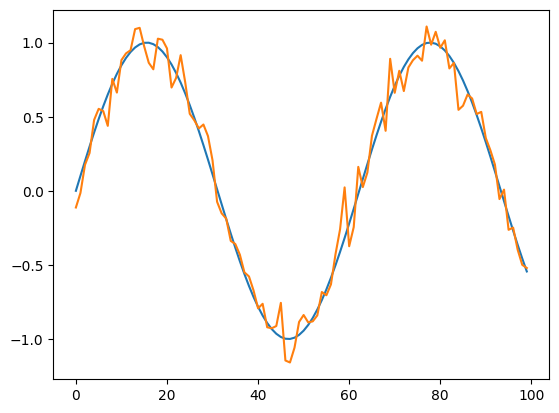

In [17]:
signal = torch.linspace(0, 10, 100).sin()
def generate_noisy_signal(seed):
    """Generates a signal given a random seed"""
    torch.manual_seed(seed)
    return signal + torch.distributions.Normal(0, 0.1).sample((100,))
    
plt.plot(signal)
plt.plot(generate_noisy_signal(0))

Here, the noisy curve will be our input signal and the "pure" sinusoidal curve will be used as our training label.
We can now proceed to input the noisy signal into the network and see how bad it is.
We're using a starting (inverse) time constant of 100, but feel free to try others.
Maybe you can already get an idea about a reasonable range of the time constants?

In [149]:
p = norse.torch.LIBoxParameters(tau_mem_inv=torch.tensor([100.]))
network = norse.torch.Lift(norse.torch.LIBoxCell(p))

def loss_signal(x):
    return ((x.squeeze() - signal) ** 2).sum()
    
# Calculate and plot the network output and loss
# out = ...
# loss = ...
# plt.gca().set_title(f"Loss {loss}")
# plt.plot(out, label="Network output")
# plt.plot(signal, label="Label signal")
# plt.legend()

### Task 2.1 Inspect the gradients

With the network predictions and loss, we can now manually calculate the gradients.
To inspect the gradient, we access the `.grad` property on the relevant tensor.
Can you find the tensor in the network somewhere?

Hint: If you use the `Lift` module, you can access the `LIBoxCell` via `network.lifted_module`.

In [128]:
# loss = ...
# loss.backward()

# Find and show the gradient of the time constant in your network
# ...

### Task 2.2 Optimize the time constant using `torch.optim`

Manually optimizing gradients is cumbersome and we prefer to use tailored algorithms instead.
Those algorithms lie in `torch.optim` and require a list of parameters to optimize.
First, find the parameters in your network.
You can do that by using `network.parameters()`, but you will have to find some way to print them.

In [131]:
# Find and list network parameters

By now, you probably realize you're in trouble.
Why aren't there any parameters?!

Find it out and fix it in the code above.
When you succeed, the network parameters should include your time constant and you can continue below by running the optimizer.

In [154]:
# 1. Register the parameters in the optimizer
# parameters = ...
# optimizer = torch.optim.Adam(parameters)

# 2. Calculate the network output and loss
# out = ...
# loss = ...

# 3. Backpropagate and step the optimizer
# loss.backward
# optimizer.step()

# 4. Find and show the new time constant. Did it change?

## Task 3: Implement high-pass filter with LIF

In this task, we will literally use a LIF as a high-pass filter to filter the sound signal we played with last week.
Instead of just applying a single LIF neuron to each channel, we are going to look at the **neighboring** channels (self included). And, if there is sufficient activity in the neighbors, then allow the LIF neuron to spike.
Effectively, we are high-pass filtering the sound across channels because we will only emit spikes when sufficient input arrives---in a spatial region.

First, let us download and show the raw signal (left) and target label (right).

In [308]:
data_file, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module1/sound_data.dat")
label_file, _ = urlretrieve("https://github.com/ncskth/phd-course/raw/main/book/module2/sound_label.dat")
data = torch.load(data_file)
label = torch.load(label_file)
f, (a1, a2) = plt.subplots(1, 2, figsize=(12, 4))
a1.set_title("Original sound sample")
a1.imshow(data, aspect="auto", vmax=0.1)
a1.set_title("Target sound sample")
a2.imshow(label, aspect="auto", vmax=0.1)

HTTPError: HTTP Error 404: Not Found

To solve this problem, you have to

1. Find a way to spatially sum 10 neighboring channels.
    * One way to do this would be by a convolution. Note that you should (1) ensure all weights are set to `1`, (2) remove any bias (`bias=None`) and (3) use `padding="same"` to retain the same number of channels.
    * Another solution would be to manually create the weight matrix in a `torch.nn.Linear` layer.
2. Create a LIF neuron with a sample time constant that receives the spatially summed signal from above.
3. Create a loss function that compares the network output with the label.
4. Create an optimizer that can optimize the `tau_mem_inv` time constant in your LIF neuron to identify the correct value.

In [279]:
# 1. Find a way to spatially sum the 10 neighboring channels
...

In [302]:
# 2. Create a LIF neuron with a sample time constant
p = norse.torch.LIFBoxParameters(tau_mem_inv=200)
lif = norse.torch.Lift(norse.torch.LIFBoxCell(p))

In [306]:
# 3. Create a loss function
def loss_fn(prediction, label):
    ...

In [307]:
# 4. Create an optimizer that can optimize the time constant of the LIF neuron
...